# Canny Edge Detection

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.filters import convolve
from scipy import ndimage

def visualize(img,val = ''):
    if val == 'Gray':
        plt.imshow(img,cmap='gray')
    else:
        plt.imshow(img)
    plt.show()


# Weighed or luminosity method

Red has more wavelength and green has not only less wavelength than red but also gives a soothing effect to our eyes.Hence major contribution must be given to green,less contribution to red and constribution of blue must be in between these two.

In [2]:
def rgb2gray(img):
    r,g,b = img[:,:,0],img[:,:,1],img[:,:,2]
    gray = 0.3 * r + 0.59 * g + 0.11 * b
    return gray

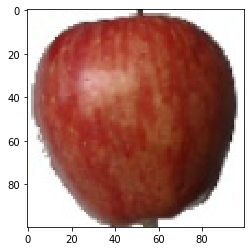

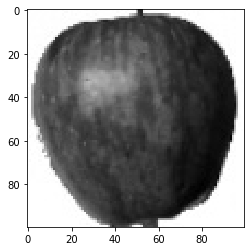

In [3]:
img=plt.imread('Apple.jpg')
visualize(img)
gray = rgb2gray(img)
visualize(gray,"Gray")

# Step 1

# Noise Reduction 

In edge detection,results are highly sensitive to noise.One way to get rid of it to use Gaussian Blur to smooth it.To do so,image convolution technique is used with Gaussina kernel(3x3,5x5...).Basically,smaller the kernel,less visible is the blur.

For a kernel of size (2k+1)x(2k+1) the Gaussian kernel equation is given by
     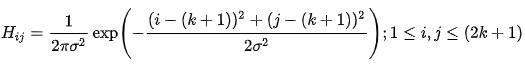
   
   
   

In [4]:

def gaussian_kernel(size, sigma=1):
    size = int(size) // 2
    x, y = np.mgrid[-size:size+1, -size:size+1]
    normal = 1 / (2.0 * np.pi * sigma**2)
    g =  np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
    return g


In [5]:
matrix = gaussian_kernel(5)
print(matrix)

[[0.00291502 0.01306423 0.02153928 0.01306423 0.00291502]
 [0.01306423 0.05854983 0.09653235 0.05854983 0.01306423]
 [0.02153928 0.09653235 0.15915494 0.09653235 0.02153928]
 [0.01306423 0.05854983 0.09653235 0.05854983 0.01306423]
 [0.00291502 0.01306423 0.02153928 0.01306423 0.00291502]]


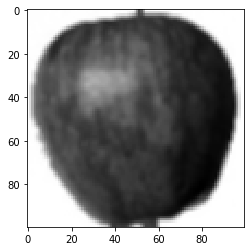

In [6]:
smoothed_img = convolve(gray, gaussian_kernel(3,3))
visualize(smoothed_img,'Gray')

# Convolution

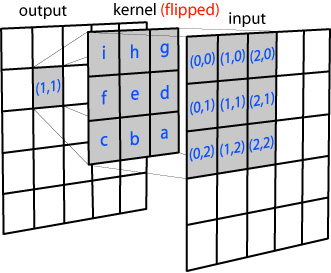

Convolution can be done by multiplying each input pixel with the entire kernel. However, if the kernel is symmetrical (which a Gaussian kernel is) you can also multiply each axis (x and y) independently, which will decrease the total number of multiplications. In proper mathematical terms, if a matrix is separable it can be decomposed into (M×1) and (1×N) matrices.

# Step 2
# Gradient Calculation

Gradient calculation detects the edge intensity and direction using gradient of an image using edge detection operator.Edge corresponds to change in intensity and to detect it the easiest way is to apply filters to highlight this intensity in both horizontal(x) and vertical(y) directions.

When the image is smoothed, the derivatives Ix and Iy w.r.t. x and y are calculated. It can be implemented by convolving I with Sobel kernels Kx and Ky, respectively:
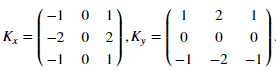


Then, the magnitude G and the slope θ of the gradient are calculated as follow:
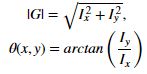

In [7]:

def sobel_filters(img):
    Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
    Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)

    Ix = convolve(img, Kx)
    Iy = convolve(img, Ky)

    G = np.hypot(Ix, Iy)
    G = G / G.max() * 255
    theta = np.arctan2(Iy, Ix)

    return (G, theta)



The gradient intensity level int the below result is between 0 and 255 which is not uniform. The edges on the final result should have the same intensity (i-e. white pixel = 255).

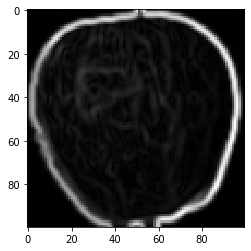

In [8]:
gradient_matrix,theta_matrix = sobel_filters(smoothed_img)

visualize(gradient_matrix,'Gray')

# Step 3 
# Non-maximum Supression

 The final image should have thin edges. Thus, we must perform non-maximum suppression to thin out the edges.
The principle is simple: the algorithm goes through all the points on the gradient intensity matrix and finds the pixels with the maximum value in the edge directions.

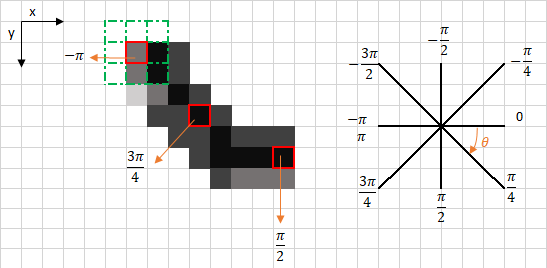









The purpose of the algorithm is to check if the pixels on the same direction are more or less intense than the ones being processed. In the example below, the pixel (i, j) is being processed, and the pixels on the same direction are highlighted in blue (i, j-1) and (i, j+1). If one those two pixels are more intense than the one being processed, then only the more intense one is kept. Pixel (i, j-1) seems to be more intense, because it is white (value of 255). Hence, the intensity value of the current pixel (i, j) is set to 0. If there are no pixels in the edge direction having more intense values, then the value of the current pixel is kept.

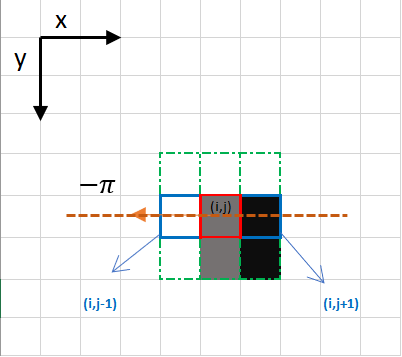


Another example
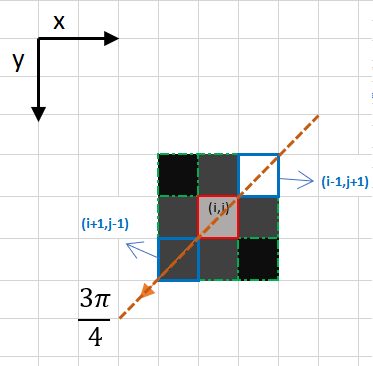

In [9]:
    
def non_max_suppression(img, D):
    M, N = img.shape
    Z = np.zeros((M,N), dtype=np.int32)
    angle = D * 180. / np.pi
    angle[angle < 0] += 180


    for i in range(1,M-1):
        for j in range(1,N-1):
            try:
                q = 255
                r = 255

               #angle 0
                if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                    q = img[i, j+1]
                    r = img[i, j-1]
                #angle 45
                elif (22.5 <= angle[i,j] < 67.5):
                    q = img[i+1, j-1]
                    r = img[i-1, j+1]
                #angle 90
                elif (67.5 <= angle[i,j] < 112.5):
                    q = img[i+1, j]
                    r = img[i-1, j]
                #angle 135
                elif (112.5 <= angle[i,j] < 157.5):
                    q = img[i-1, j-1]
                    r = img[i+1, j+1]

                if (img[i,j] >= q) and (img[i,j] >= r):
                    Z[i,j] = img[i,j]
                else:
                    Z[i,j] = 0


            except IndexError as e:
                pass

    return Z


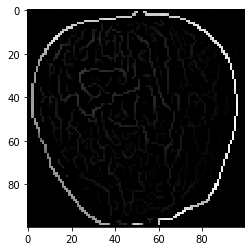

In [10]:
nonMaxImg = non_max_suppression(gradient_matrix, theta_matrix)
visualize(nonMaxImg,'Gray')

# Step 4
# Double Threshold


The double threshold step aims at identifying 3 kinds of pixels: strong, weak, and non-relevant.




Strong pixels are pixels that have an intensity so high that we are sure they contribute to the final edge.

Weak pixels are pixels that have an intensity value that is not enough to be considered as strong ones, but yet not small enough to be considered as non-relevant for the edge detection.

Other pixels are considered as non-relevant for the edge.

High threshold is used to identify the strong pixels (intensity higher than the high threshold)
Low threshold is used to identify the non-relevant pixels (intensity lower than the low threshold)
All pixels having intensity between both thresholds are flagged as weak and the Hysteresis mechanism (next step) will help us identify the ones that could be considered as strong and the ones that are considered as non-relevant.

# Step 5
# Hysteresis

Based on the threshold results, the hysteresis consists of transforming weak pixels into strong ones, if and only if at least one of the pixels around the one being processed is a strong one, as described below
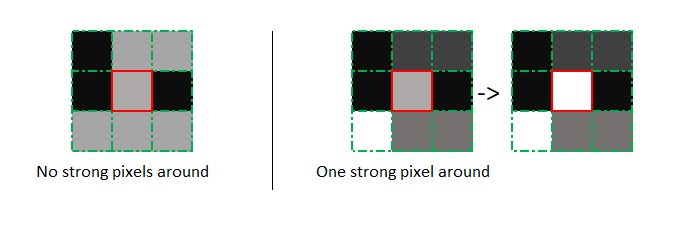

In [11]:

def threshold_histeresis(img,weak_pixel,strong_pixel,lowThreshold,highThreshold):
    
    highThreshold = img.max() * highThreshold;
    lowThreshold = highThreshold * lowThreshold;

    M, N = img.shape
    res = np.zeros((M,N), dtype=np.int32)

    weak = np.int32(weak_pixel)
    strong = np.int32(strong_pixel)

    strong_i, strong_j = np.where(img >= highThreshold)
    zeros_i, zeros_j = np.where(img < lowThreshold)

    weak_i, weak_j = np.where((img <= highThreshold) & (img >= lowThreshold))

    res[strong_i, strong_j] = strong
    res[weak_i, weak_j] = weak
    
    visualize(res,"Gray")
    
    #histeresis
    
    M, N = res.shape
    weak = weak_pixel
    strong = strong_pixel

    for i in range(1, M-1):
        for j in range(1, N-1):
            if (res[i,j] == weak):
                try:
                    if ((res[i+1, j-1] == strong) or (res[i+1, j] == strong) or (res[i+1, j+1] == strong)
                        or (res[i, j-1] == strong) or (res[i, j+1] == strong)
                        or (res[i-1, j-1] == strong) or (res[i-1, j] == strong) or (res[i-1, j+1] == strong)):
                        res[i, j] = strong
                    else:
                        res[i, j] = 0
                except IndexError as e:
                    pass

        return res


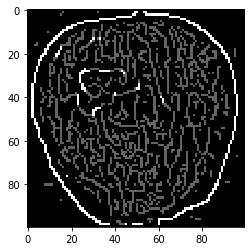

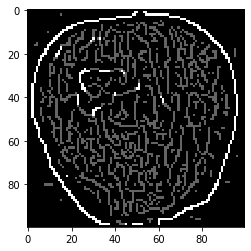

In [12]:
img_final  = threshold_histeresis(nonMaxImg,weak_pixel=100,strong_pixel=255,lowThreshold=0.05,highThreshold=0.15)
visualize(img_final,"Gray")